In [1]:
import os
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
from tensorflow import keras
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping
from PIL import Image
import re


In [ ]:
def read_cvs_file(path):
    csv_matrix = np.genfromtxt(path, delimiter=',', skip_header=1)
    return csv_matrix

In [3]:
def extract_numbers(s):
    numbers = re.findall(r'\d+', s)
    return [int(num) for num in numbers]


In [4]:
#Selecting preceding slice i-1 and current slice i
def concatenate_images(directory):
    dataset_list = []
    for subdir, dirs, files in os.walk(directory):
        files = sorted(files, key=extract_numbers)
        print("files: ", files)
        print("subdir: ", subdir)
        
        for i in range(0, len(files)-2,3):
            print("file i: ", files[i])
            print("file i+1: ", files[i+1])
            
            if files[i].endswith(extension) and files[i+1].endswith(extension):
                filepath_i = os.path.join(subdir, files[i])
                filepath_ip1 = os.path.join(subdir, files[i+1])
            
                img_i = Image.open(filepath_i)
                img_ip1 = Image.open(filepath_ip1)
            
                data_i = np.array(img_i)
                data_i = data_i / 255.

                data_ip1 = np.array(img_ip1)
                data_ip1 = data_ip1 / 255.

                if data_i.shape == data_ip1.shape:
                    # Concatena lungo la terza dimensione
                    data = np.dstack((data_i, data_ip1))
                    data = tf.convert_to_tensor(data, dtype=(tf.float32))
                    print(data.shape)
                    dataset_list.append(data)

    return dataset_list    

In [ ]:
#Selecting current slice i and next slice i+1
def concatenate_images(directory):
    dataset_list = []
    for subdir, dirs, files in os.walk(directory):
        files = sorted(files, key=extract_numbers)
        print("files: ", files)
        print("subdir: ", subdir)
        
        for i in range(1, len(files)-1,3):
            print("file i: ", files[i])
            print("file i+1: ", files[i+1])
            
            if files[i].endswith(extension) and files[i+1].endswith(extension):
                filepath_i = os.path.join(subdir, files[i])
                filepath_ip1 = os.path.join(subdir, files[i+1])
            
                img_i = Image.open(filepath_i)
                img_ip1 = Image.open(filepath_ip1)
            
                data_i = np.array(img_i)
                data_i = data_i / 255.

                data_ip1 = np.array(img_ip1)
                data_ip1 = data_ip1 / 255.

                if data_i.shape == data_ip1.shape:
                    # Concatena lungo la terza dimensione
                    data = np.dstack((data_i, data_ip1))
                    data = tf.convert_to_tensor(data, dtype=(tf.float32))
                    print(data.shape)
                    dataset_list.append(data)

    return dataset_list

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
         
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
 latent_dim = 20

encoder_inputs = keras.Input(shape=(100, 200, 2))
#x = data_augmentation(encoder_inputs)
x = layers.Conv2D(32, 3, activation=keras.layers.LeakyReLU(alpha=0.2), strides=2, padding="same",
                  kernel_initializer=keras.initializers.LecunNormal(),kernel_regularizer=l2(0.1))(encoder_inputs)
x = layers.Dropout(0.7)(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = layers.Conv2D(32, 3, activation=keras.layers.LeakyReLU(alpha=0.2), strides=2, padding="same",kernel_initializer=keras.initializers.LecunNormal(),
                  kernel_regularizer=l2(0.1))(x)
x = layers.Dropout(0.7)(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(alpha=0.2), strides=2, padding="same",kernel_initializer=keras.initializers.LecunNormal(),
                  kernel_regularizer=l2(0.1))(x)
x = layers.Dropout(0.7)(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)


x = layers.Conv2D(64, 3, activation=keras.layers.LeakyReLU(alpha=0.2), strides=2, padding="same",kernel_initializer=keras.initializers.LecunNormal(),
                  kernel_regularizer=l2(0.1))(x)
x = layers.Dropout(0.7)(x)
x = layers.BatchNormalization(axis=1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)

x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean", activation= tf.identity,kernel_regularizer=l1(0.01), 
                      kernel_initializer=keras.initializers.RandomNormal())(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var", activation= tf.identity,kernel_regularizer=l1(0.01),
                         kernel_initializer=keras.initializers.RandomNormal())(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 200, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 100, 32)          608       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 50, 100, 32)          0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 50, 100, 32)          200       ['dropout[0][0]']             
 Normalization)                                                                             

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(25 * 50 * 64, activation=keras.layers.LeakyReLU(alpha=0.2), kernel_initializer=keras.initializers.LecunNormal(), 
                 kernel_regularizer=l2(0.1))(latent_inputs)
x = layers.Reshape((25, 50, 64))(x)

x = layers.Conv2DTranspose(64, 9, activation=keras.layers.LeakyReLU(alpha=0.2), strides=2, padding="same",
                           kernel_initializer=keras.initializers.LecunNormal(),kernel_regularizer=l2(0.1))(x)
x = layers.Dropout(0.8)(x)
x = layers.BatchNormalization()(x) 


x = layers.Conv2DTranspose(32, 7, activation=keras.layers.LeakyReLU(alpha=0.2), strides=2, padding="same",
                           kernel_initializer=keras.initializers.LecunNormal(),kernel_regularizer=l2(0.1))(x)
x = layers.Dropout(0.8)(x)
x = layers.BatchNormalization()(x)  

x = layers.Conv2DTranspose(16, 5, activation=keras.layers.LeakyReLU(alpha=0.2), strides=1, padding="same",
                           kernel_initializer=keras.initializers.LecunNormal(),kernel_regularizer=l2(0.1))(x)
x = layers.Dropout(0.7)(x)
x = layers.BatchNormalization()(x) 

decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same", activation='sigmoid', 
                                         kernel_initializer =keras.initializers.RandomNormal(), kernel_regularizer=l2(0.1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 80000)             1680000   
                                                                 
 reshape (Reshape)           (None, 25, 50, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 50, 100, 64)       331840    
 anspose)                                                        
                                                                 
 dropout_4 (Dropout)         (None, 50, 100, 64)       0         
                                                                 
 batch_normalization_4 (Bat  (None, 50, 100, 64)       256       
 chNormalization)                                          

In [8]:
# Vae training on generating preceding slice
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.ssim_loss_tracker = keras.metrics.Mean(name="ssim_loss")
        
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.val_kl_loss_tracker = keras.metrics.Mean(name="val_kl_loss")
        self.val_ssim_loss_tracker = keras.metrics.Mean(name="val_ssim_loss")
        


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.ssim_loss_tracker
        ]


    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            data_i = data[..., 0]
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction = tf.squeeze(reconstruction, axis=-1)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data_i - reconstruction), axis=(1, 2)))
    
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            ssim_loss = tf.reduce_mean(tf.image.ssim(data_i, reconstruction, max_val=1.0))

            total_loss = reconstruction_loss + 1.5*kl_loss -ssim_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.ssim_loss_tracker.update_state(ssim_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "ssim_loss": self.ssim_loss_tracker.result()
        }
    
    def test_step(self, data):
        with tf.GradientTape() as tape:
            data_i = data[..., 0]
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction = tf.squeeze(reconstruction, axis=-1)
            val_reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data_i - reconstruction), axis=(1, 2)))
            val_kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            val_kl_loss = tf.reduce_mean(tf.reduce_sum(val_kl_loss, axis=1))
            val_ssim_loss=tf.reduce_mean(tf.image.ssim(data_i, reconstruction, max_val=1.0))

            val_total_loss = val_reconstruction_loss + 1.5*val_kl_loss - val_ssim_loss
        
        self.val_total_loss_tracker.update_state(val_total_loss)
        self.val_reconstruction_loss_tracker.update_state(val_reconstruction_loss)
        self.val_kl_loss_tracker.update_state(val_kl_loss)
        self.val_ssim_loss_tracker.update_state(val_ssim_loss)
        return {
            "loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "kl_loss": self.val_kl_loss_tracker.result(),
            "ssim_loss": self.val_ssim_loss_tracker.result(),
        }
    

In [34]:
training_dir = "path to training directory"
test_dir = "path to test directory"
validation_dir = "path to validation directory"
extension = ".png"


In [ ]:
train_images = concatenate_images(training_dir)
validation_images = concatenate_images(validation_dir)
test_images = concatenate_images(test_dir)



buffer_size = 2000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_images)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

batch_size = 64
train_dataset = train_dataset.batch(batch_size)

validation_dataset = validation_dataset.batch(batch_size)

test_dataset = test_dataset.batch(batch_size)

train_dataset = train_dataset.shuffle(buffer_size)


In [11]:
vae = CVAE(encoder, decoder)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
history = vae.fit(train_dataset, epochs=300, validation_data=validation_dataset,callbacks=[early_stopping])


Epoch 1/300
15/15 [==============================] - 74s 5s/step - loss: 1372.1993 - reconstruction_loss: 1362.3337 - kl_loss: 20.5673 - ssim_loss: 0.1849 - val_loss: 1702.2360 - val_reconstruction_loss: 1696.6437 - val_kl_loss: 3.7788 - val_ssim_loss: 0.0761
Epoch 2/300
15/15 [==============================] - 34s 2s/step - loss: 1274.6600 - reconstruction_loss: 1280.3997 - kl_loss: 22.9441 - ssim_loss: 0.2021 - val_loss: 1666.7234 - val_reconstruction_loss: 1659.1310 - val_kl_loss: 5.1202 - val_ssim_loss: 0.0882
Epoch 3/300
15/15 [==============================] - 79s 5s/step - loss: 1329.6160 - reconstruction_loss: 1222.0907 - kl_loss: 24.6229 - ssim_loss: 0.2189 - val_loss: 1632.5724 - val_reconstruction_loss: 1623.2083 - val_kl_loss: 6.3101 - val_ssim_loss: 0.1010
Epoch 4/300
15/15 [==============================] - 79s 5s/step - loss: 1230.6069 - reconstruction_loss: 1177.2747 - kl_loss: 24.3313 - ssim_loss: 0.2318 - val_loss: 1601.5963 - val_reconstruction_loss: 1590.5985 - val_

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VAE Loss')
plt.legend()
plt.show()

2/2 [==============================] - 2s 1s/step
(100, 200, 1)
(100, 200)


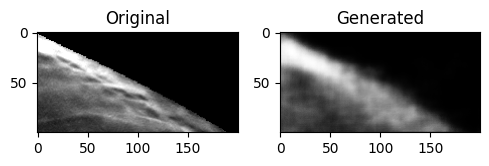

In [24]:
import random

# Executing inference on training images
num_test_images = 10
random_index = random.randint(0, num_test_images - 1)
random_image = next(iter(train_dataset.skip(random_index).take(1)))
num_images_to_generate = 1

z_mean, _, z = vae.encoder.predict(random_image)
generated_image = vae.decoder.predict(z)
generated_image = generated_image[0]
random_image = random_image[0][...,0]
print(generated_image.shape)
print(random_image.shape)
plt.figure(figsize=(5, 5))
for i in range(num_images_to_generate):
    plt.subplot(num_images_to_generate, 2, 2*i + 1)
    plt.imshow(random_image, cmap='gray')
    plt.title('Original')

    plt.subplot(num_images_to_generate, 2, 2*i + 2)
    plt.imshow(generated_image, cmap='gray')
    plt.title('Generated')

plt.tight_layout()
plt.show()


In [ ]:
"""Augmenting dataset with new images produced by VAE"""

lista = []
for subdir, dirs, files in os.walk(validation_dir):
        files = sorted(files, key=extract_numbers)
        print("files: ", files)
        print("subdir: ", subdir)
        
        for i in range(1, len(files)-1,3):
            print("file i: ", files[i])
            print("file i+1: ", files[i+1])
            
            if files[i].endswith(extension) and files[i+1].endswith(extension):
                filepath_i = os.path.join(subdir, files[i])
                filepath_ip1 = os.path.join(subdir, files[i+1])
            
                img_i = Image.open(filepath_i)
                img_ip1 = Image.open(filepath_ip1)
            
                data_i = np.array(img_i)
                data_i = data_i / 255.

                data_ip1 = np.array(img_ip1)
                data_ip1 = data_ip1 / 255.

                if data_i.shape == data_ip1.shape:
                    data = np.dstack((data_i, data_ip1))
                    data = tf.convert_to_tensor(data, dtype=(tf.float32))
                    data = tf.expand_dims(data, axis=0)
                    print(data.shape)
                    z_mean, _, z = vae.encoder.predict(data)
                    
                    generated_image = vae.decoder.predict(z)
                    generated_image = generated_image.astype(np.float32)
        
        
                    generated_image = (generated_image*255.)

                    generated_image = generated_image.squeeze()
                    generated_image = tf.expand_dims(generated_image, axis=-1)
                    generated_image = generated_image.numpy()

                    output_filename = os.path.splitext(files[i])[0] + '_generated.png'
                    output_path = os.path.join(subdir, output_filename)
                    
                    generated_image_pil = Image.fromarray(generated_image.squeeze())
                    generated_image_pil = generated_image_pil.convert("L")
        
                    generated_image_pil.save(output_path, format="PNG")
